# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from timm.data import set_img_extensions
from torch.autograd import Variable

from sklearn.svm import LinearSVC

ModuleNotFoundError: No module named 'sklearn'

# Partie 1 : Architecture VGG16

In [2]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2024-11-06 16:38:38--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 64:ff9b::8c52:7903, 140.82.121.4
Connecting to github.com (github.com)|64:ff9b::8c52:7903|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2024-11-06 16:38:39--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: 'imagenet_classes.pkl.1'

     0K .......... .......... .......... ....                 100% 4.65M=0.007s

2024-11-06 16:38:39 (4.65

D:\anaconda3\envs\rld\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda3\envs\rld\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Text(0.5, 1.0, 'prediction: Egyptian cat')

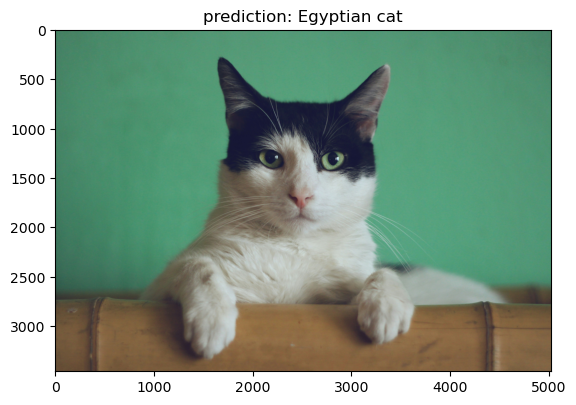

In [2]:
nameim = "cat"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])
# Expand mu & sigma to match image size
# YOUR CODE HERE
mu = mu.unsqueeze(-1).unsqueeze(-1)
sigma = sigma.unsqueeze(-1).unsqueeze(-1)
# compute the normalized image with mean ImageNet image
img = (torch.Tensor(img) - mu) / sigma 

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval() # WHY THAT ?

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x)
y = y.detach().numpy() # transformation en array numpy

# Get prediction (i.e., ImageNet class label)
# YOUR CODE HERE
plt.title(f'prediction: {imagenet_classes[np.argmax(y)]}')


Text(0.5, 1.0, 'prediction: wire-haired fox terrier')

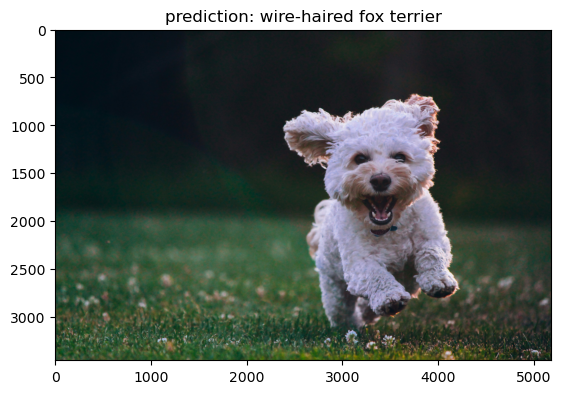

In [3]:
nameim = "dog"+".jpg"
#cat = Image.open('cat.jpg')
img = Image.open(nameim)
plt.imshow(img)

# Loading ImageNet classes
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))

# Normalization
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# ImageNet mean/std
mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])
# Expand mu & sigma to match image size
# YOUR CODE HERE
mu = mu.unsqueeze(-1).unsqueeze(-1)
sigma = sigma.unsqueeze(-1).unsqueeze(-1)
# compute the normalized image with mean ImageNet image
img = (torch.Tensor(img) - mu) / sigma 

# Loding pre-trained VGG
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.eval() # WHY THAT ?

# Forward pass on VGG
img = np.expand_dims(img, 0)
x = torch.Tensor(img)
y = vgg16(x)
y = y.detach().numpy() # transformation en array numpy

# Get prediction (i.e., ImageNet class label)
# YOUR CODE HERE
plt.title(f'prediction: {imagenet_classes[np.argmax(y)]}')

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [16]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2024-11-06 16:43:33--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 64:ff9b::8c52:7904, 140.82.121.4
Connecting to github.com (github.com)|64:ff9b::8c52:7904|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2024-11-06 16:43:34--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: '15ScenesData.zip'

     0K .......... .......... .......... .......... ..........  0%  250K 5m38s
    50K .......... .......... .......

Archive:  15ScenesData.zip
   creating: 15SceneData/          
   creating: 15SceneData/test/     
   creating: 15SceneData/test/industrial/
  inflating: 15SceneData/test/industrial/image_0248.jpg  
  inflating: 15SceneData/test/industrial/image_0297.jpg  
  inflating: 15SceneData/test/industrial/image_0091.jpg  
  inflating: 15SceneData/test/industrial/image_0167.jpg  
  inflating: 15SceneData/test/industrial/image_0037.jpg  
  inflating: 15SceneData/test/industrial/image_0244.jpg  
  inflating: 15SceneData/test/industrial/image_0135.jpg  
  inflating: 15SceneData/test/industrial/image_0015.jpg  
  inflating: 15SceneData/test/industrial/image_0182.jpg  
  inflating: 15SceneData/test/industrial/image_0243.jpg  
  inflating: 15SceneData/test/industrial/image_0258.jpg  
  inflating: 15SceneData/test/industrial/image_0008.jpg  
  inflating: 15SceneData/test/industrial/image_0005.jpg  
  inflating: 15SceneData/test/industrial/image_0169.jpg  
  inflating: 15SceneData/test/industrial/image_

In [4]:
print(list(vgg16.features.children()))

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), ReLU(inplace=True), Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [5]:
print(list(vgg16.classifier.children()))

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=1000, bias=True)]


In [6]:
class VGG16relu17(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(*list(vgg16.features.children()))
        self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x

In [7]:

PRINT_INTERVAL = 50
CUDA = True

mu = torch.Tensor([0.485, 0.456, 0.406])
sigma = torch.Tensor([0.229, 0.224, 0.225])

def get_dataset(batch_size, path):

    # This function expands 3 times a gray level image
    # to transform it into an image RGB. Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img
    def resizeImage(img):
      return img.resize((224,224), Image.BILINEAR)
    
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pre-processing TODO: duplicateChannel(), resizeImage(), toTensor(), Normalize ()
            duplicateChannel,
            resizeImage,
            transforms.ToTensor(),
            transforms.Normalize(mean=mu, std=sigma),
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pre-processing TODO
            duplicateChannel,
            resizeImage,
            transforms.ToTensor(),
            transforms.Normalize(mean=mu, std=sigma),
        ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=0)

    return train_loader, val_loader

In [8]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
def extract_features(data, model):
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # init features matrices
    X = []
    y = []
    ####################
    ##      END        #
    ####################
    
    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## YOUR CODE HERE  ##
        #####################
        # Feature extraction à faire
        X.append(model(input))
        y.append(target)
        ####################
        ##      END        #
        ####################

    return torch.cat(X), torch.cat(y)


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## YOUR CODE HERE  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu17().to('cuda' if CUDA else 'cpu')
    ####################
    ##      END        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    svm = LinearSVC(C=1.0)
    
    
    print('Apprentissage des SVM')
    svm.fit(X_train, y_train)
    prediction = svm.predict(X_test)
    
    accuracy = accuracy_score(prediction, y_test)
    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)


In [9]:
main("15SceneData", 8)

Instanciation de VGG16
Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
